<a href="https://colab.research.google.com/github/JaimeRedondo/Mushrooms_Classification/blob/master/Mushrooms_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries Import

In [2]:
#working with images
! pip install opencv-python
from matplotlib import image
from matplotlib import pyplot
from skimage import io
import cv2
import os
import skimage
from skimage import data, io, filters, transform

#--Web scraping packages
from bs4 import BeautifulSoup
import requests
import itertools
from urllib.request import Request, urlopen
import urllib.request

#Pandas/numpy for data manipulation
import pandas as pd
import numpy as np
from urllib.request import urlopen

#barrita de progreso
from tqdm.notebook import tqdm
from time import sleep 

#Visualize data
%pylab inline
plt.style.use('seaborn-talk')

#import deep learning libraries
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras import metrics
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import Input
import tensorflow as tf



Populating the interactive namespace from numpy and matplotlib


In [3]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


# Define Functions



Plotting function to see test and validation accuracy


In [4]:
#To plot test,train,and validation accuracy metrics.

def plot_metric(history, metric):
    history_dict = history.history
    values = history_dict[metric]
    if 'val_' + metric in history_dict.keys():  
        val_values = history_dict['val_' + metric]

    epochs = range(1, len(values) + 1)

    if 'val_' + metric in history_dict.keys():  
        plt.plot(epochs, val_values, label='Validation')
    plt.semilogy(epochs, values, label='Training')

    if 'val_' + metric in history_dict.keys():  
        plt.title('Training and validation %s' % metric)
    else:
        plt.title('Training %s' % metric)
    plt.xlabel('Epochs')
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.grid()

    plt.show()  


#to see mushrooms when I want
def plot_mushroom_image(N, imgs, labels):
    print(labels[N])
    plt.imshow(imgs[N,], cmap=plt.cm.binary)
    plt.grid(True)

In [5]:
mushrooms_directory=[]
for folder in tqdm(os.listdir('/content/drive/MyDrive/Mushrooms_Classification')):
    if '.' in folder:
        pass
    else:
        mushrooms_directory.append(folder)
        
mushrooms_directory=sorted(mushrooms_directory)

In [6]:
mushrooms_directory[0:5],len(mushrooms_directory)

(['Abortiporus biennis',
  'Adelphella babingtonii',
  'Agaricus arvensis',
  'Agaricus campestris',
  'Agaricus litoralis'],
 538)

In [21]:
setas_guadalajara = ['Agaricus arvensis','Agaricus bitorquis','Agaricus campestris','Agaricus sylvaticus','Amanita caesarea','Amanita citrina',
                     'Amanita curtipes','Amanita muscaria','Amanita pantherina','Amanita phalloides','Boletus aereus','Boletus aestivalis','Boletus edulis',
                     'Boletus erythropus','Boletus luridus','Boletus pinophilus','Boletus satanas','Cantharellus cibarius','Clitocybe gibba','Clitocybe odora',
                     'Cratarellus cornucopioide','Cratarellus lutescens','Ganoderma lucidum','Lactarius controversus','Lactarius controversus','Lactarius deliciosus',
                     'Lactarius rufus','Lactarius sanguifluus','Lepista nuda','Macrolepiota mastoidea','Macrolepiota procera','Marasmius oreades','Morchella elata',
                     'Morchella esculenta','Morchella vulgaris','Pleurotus eryngii','Pleurotus ostreatus','Russula chloroides','Russula cyanoxantha','Russula vesca',
                     'Sparasis crispa','Suillus luteus','Terfecia leptoderma','Tricholoma columbetta','Tricholoma equestre','Tricholoma portentosum','Tuber aestivum',
                     'Tuber brumale','Tuber melanosporum']

In [23]:
setas_guada=[]
for i in setas_guadalajara:
  if i in mushrooms_directory:
    setas_guada.append(i)
  else:
    print('no está '+i)

no está Agaricus bitorquis
no está Boletus aestivalis
no está Boletus luridus
no está Boletus satanas
no está Cratarellus cornucopioide
no está Cratarellus lutescens
no está Lactarius rufus
no está Morchella vulgaris
no está Sparasis crispa
no está Terfecia leptoderma


In [26]:
type(mushrooms_directory)

list

In [71]:
#resize all images shape in 28x28 and print what photos are not available
def resize_photos(directory):
    
    for folder in tqdm(directory):
        for numero in range(20):
            try:
                route = '/content/drive/MyDrive/Mushrooms_Classification/'+folder +'/'+ str(numero) + '.jpg'
                data_picture = io.imread(route)
                data_picture = cv2.resize(data_picture, (100, 100))
                # save the images
                cv2.imwrite(route,data_picture)
            except:  
                print("imagen "+str(numero)+' de la seta '+folder+' no está disponible')

#standarize 0_255 pixels to 0 - 1.
lista=[]
lista1=[]
def standarize_pixels_and_augmentation(directory):
    for folder in tqdm(directory):
        for numero in range(20):
            try:
                route ='/content/drive/MyDrive/Mushrooms_Classification/'+folder +'/'+ str(numero) + '.jpg'
                image_rgb=io.imread(route)/255.0

                ##DATA AUGMENTATION##

                flip_1 = np.fliplr(image_rgb)
                #mirror with vertical line on right


                rot_90 = tf.image.rot90(image_rgb, k=1)
                rot_180 = tf.image.rot90(image_rgb, k=2)
                rot_270 = tf.image.rot90(image_rgb, k=3)
                #rotation of 90, 180 and 270 grades

                #now we are going to crop the imgs, can be whatever siza of crop we want
                height, width = image_rgb.shape[0:2]

                startRow = int(height*.15)

                startCol = int(width*.15)

                endRow = int(height*.85)

                endCol = int(width*.85)

                croppedImage = image_rgb[startRow:endRow, startCol:endCol]

                croppedImage = cv2.resize(croppedImage, (100, 100))

                #now we are going to add contrast

                contrast_img = cv2.addWeighted(image_rgb, 1.5, np.zeros(image_rgb.shape, image_rgb.dtype), 0, 0)

                #desenfoque del 50% cogiendo la mediana de los pixeles
                blur_image = cv2.medianBlur(image_rgb,1)

                #add to list

                lista.append(image_rgb)
                lista.append(flip_1)
                lista.append(rot_90)
                lista.append(rot_180)
                lista.append(rot_270)
                lista.append(croppedImage)
                lista.append(contrast_img)
                lista.append(blur_image)
                lista1.append(folder)
                lista1.append(folder)
                lista1.append(folder)
                lista1.append(folder)
                lista1.append(folder)
                lista1.append(folder)
                lista1.append(folder)
                lista1.append(folder)

            except:
                print(folder+str(numero))                


def standarize_photos(directory):
    print("reshaping pictures...")
    resize_photos(directory)
    print("Normalizing pixels...")
    standarize_pixels_and_augmentation(directory)  

# Preparing data

In [72]:
standarize_photos(setas_guada)

reshaping pictures...



Normalizing pixels...


### pasar de largo

In [ ]:
#para guardar el objeto lista en un archivo en python

import pickle

# Guardar la lista en el archivo "Data_Mushrooms.pickle".
obj = np.array(lista)
with open("Data_Mushrooms.pickle", "wb") as f:
    pickle.dump(obj, f)

In [ ]:
#para guardar el objeto lista en un archivo en python

import pickle

# Guardar la lista en el archivo "Data_Mushrooms.pickle".
obj = np.array(lista1)
with open("Data_Mushrooms_labels.pickle", "wb") as f:
    pickle.dump(obj, f)

In [ ]:
from google.colab import files
files.upload()

Saving Data_Mushrooms.pickle to Data_Mushrooms.pickle


KeyboardInterrupt: ignored

In [ ]:
#para recuperar el objeto guardado:

with open("Data_Mushrooms.pickle", "rb") as f:
    lista2 = pickle.load(f)

### seguimos

In [73]:
images = np.array(lista)

labels = np.array(lista1)

In [74]:
images.shape,labels.shape

((6240, 100, 100, 3), (6240,))

In [75]:
# creamos lista para coger el conjunto de test

import random 

randomizado = np.array(range(0,len(images)))
enteros_aleatorios = randint(0,len(images),int(len(images)*0.20))

In [76]:
mask = pd.Series(randomizado).isin(enteros_aleatorios)

In [77]:
test_images = images[mask]
test_labels = labels[mask]
trainval_images = images[~mask]
trainval_labels = labels[~mask]

In [78]:
### y ahora saco validation

randomizado1 = np.array(range(0,len(trainval_images)))
enteros_aleatorios1 = randint(0,len(trainval_images),int(len(trainval_images)*0.10))

mask1 = pd.Series(randomizado1).isin(enteros_aleatorios1)

validation_images = trainval_images[mask1]
validation_labels = trainval_labels[mask1]
train_images = trainval_images[~mask1]
train_labels = trainval_labels[~mask1]

In [79]:
test_labels

array(['Agaricus arvensis', 'Agaricus arvensis', 'Agaricus arvensis', ...,
       'Tuber melanosporum', 'Tuber melanosporum', 'Tuber melanosporum'],
      dtype='<U22')

In [80]:
#### Ya tenemos los datos preparados en test y train

In [81]:
train_images.shape,test_images.shape

((4623, 100, 100, 3), (1129, 100, 100, 3))

Agaricus sylvaticus


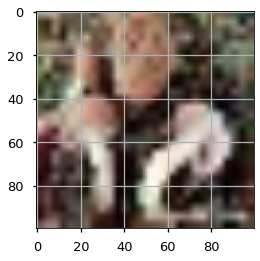

In [82]:
plot_mushroom_image(79,test_images,test_labels)

In [83]:
l2 = list(np.unique(labels))

In [84]:
len(l2)

38

In [85]:
l1 = list(range(538))
l2 = list(np.unique(labels))
d = dict(zip(l1,l2))
#create a dictionary to use one hot encoder

Transform to one hot encoder the 538 classes 

In [86]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

In [87]:
ohetrain = OneHotEncoder(sparse = False)
le = LabelEncoder()
OneHotTrain = ohetrain.fit_transform(le.fit_transform(train_labels).reshape(-1, 1))

In [88]:
ohetest = OneHotEncoder(sparse = False)
le = LabelEncoder()
OneHotTest = ohetest.fit_transform(le.fit_transform(test_labels).reshape(-1, 1))

In [89]:
oheval = OneHotEncoder(sparse = False)
le = LabelEncoder()
OneHotVal = oheval.fit_transform(le.fit_transform(validation_labels).reshape(-1, 1))

In [90]:
OneHotVal.shape

(488, 38)

In [91]:
#transformamos a onehot nuestros targets 

OneHotTrain.shape,OneHotTest.shape,OneHotVal.shape

((4623, 38), (1129, 38), (488, 38))

In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

# Applying CNN (Convolutional Neural Network)

Vamos a crear nuestra primera red neuronal convolucional

In [120]:
def build():  
  model = Sequential()

  model.add(Conv2D(filters = 10, kernel_size = (10,10),padding = 'Same', 
                 activation ='relu', input_shape = (100,100,3)))
  model.add(Conv2D(filters = 8, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
  model.add(MaxPool2D(pool_size=(3,3)))
  model.add(Dropout(0.5))


  #model.add(Conv2D(filters = 16, kernel_size = (3,3),padding = 'Same', 
                 #activation ='relu'))
  #model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                 #activation ='relu'))
  #model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
  #model.add(Dropout(0.5))


  model.add(Flatten())
  #model.add(Dense(1000, activation = "relu"))
  #model.add(Dropout(0.5))

  model.add(Dense(38, activation = "softmax"))

  model.summary()

  return model

In [109]:
#### otro modelo

def build():  
  model = Sequential()

  model.add(Conv2D(filters = 16, kernel_size = (10,10),padding = 'Same', 
                  activation ='relu', input_shape = (100,100,3)))

  model.add(Conv2D(filters = 32, kernel_size = (7,7),padding = 'Same', 
                  activation ='relu'))
  model.add(MaxPool2D(pool_size=(2,2)))

  model.add(Dropout(0.25))


  model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                  activation ='relu'))
  
  model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                  activation ='relu'))
  model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
  model.add(Dropout(0.25))


  model.add(Flatten())
  model.add(Dense(300, activation = "relu"))
  model.add(Dropout(0.5))
  model.add(Dense(38, activation = "softmax"))

  return model

In [121]:
model=build()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 100, 100, 10)      3010      
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 100, 100, 8)       2008      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 33, 33, 8)         0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 33, 33, 8)         0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 8712)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 38)                331094    
Total params: 336,112
Trainable params: 336,112
Non-trainable params: 0
________________________________________________

In [112]:
#### 2 optimizadores a ver cual funciona mejor

In [122]:
model.compile(optimizer=optimizers.Adam(),loss=losses.categorical_crossentropy,metrics=[metrics.categorical_accuracy])

In [30]:
#### probamos con sgd

model.compile(optimizer=optimizers.SGD(lr=0.01),loss=losses.categorical_crossentropy,metrics=[metrics.categorical_accuracy])

In [98]:
train_images.shape,validation_images.shape

((4623, 100, 100, 3), (488, 100, 100, 3))

In [99]:
OneHotTrain.shape,OneHotVal.shape

((4623, 38), (488, 38))

y vamos con el modelo

In [ ]:
 h = model.fit (train_images,OneHotTrain,batch_size= 100,epochs=30,validation_data=(validation_images,OneHotVal))

Epoch 1/30
47/47 [==============================] - ETA: 0s - loss: 3.5533 - categorical_accuracy: 0.0463

### Evaluating the model

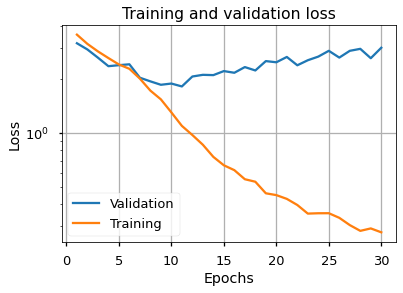

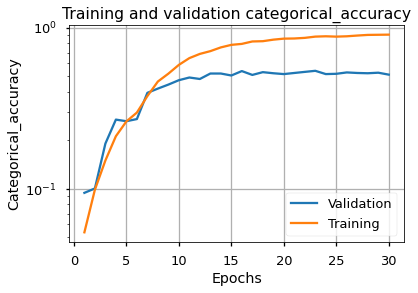

In [115]:
plot_metric(h,'loss')
plot_metric(h,'categorical_accuracy')

In [63]:
model.evaluate(test_images,OneHotTest)

36/36 [==============================] - 0s 5ms/step - loss: 2.5723 - categorical_accuracy: 0.6281


[2.572279930114746, 0.628113865852356]

### Doing predictions

In [ ]:
y_pred = model.predict_classes(test_images)
y_pred

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


array([  0, 193, 395, ..., 363, 466, 469])

In [ ]:
type(test_images)

numpy.ndarray

In [ ]:
test_labels
target_names = pd.Series(test_labels).drop_duplicates()

In [ ]:
d.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219,

In [ ]:
predictions=[]
for i in y_pred:
  predictions.append(d.get(i))

In [ ]:
predictions[0:5]

['Abortiporus biennis',
 'Fuscoporia contigua',
 'Plicaturopsis crispa',
 'Psathyrella spadiceogrisea',
 'Abortiporus biennis']

In [ ]:
test_labels

array(['Abortiporus biennis', 'Abortiporus biennis',
       'Abortiporus biennis', ..., 'Xylaria polymorpha',
       'Xylaria polymorpha', 'Xylaria polymorpha'], dtype='<U29')

In [ ]:
#### vamos a comprobar con una imagen aletaria que cojo de google.

import numpy as np
from google.colab import files

uploaded=files.upload()



Saving images.jpg to images.jpg


In [ ]:
route ='/content/istockphoto-1015452220-612x612.jpg'
route1 = '/content/images.jpg'
image_rgb=io.imread(route)/255.0
image_rgb1=io.imread(route1)/255.0

In [ ]:
data_picture = cv2.resize(image_rgb, (28, 28))
data_picture1 = cv2.resize(image_rgb1, (28, 28))

In [ ]:
pictures = np.array([data_picture,data_picture1])

In [ ]:
# predecimos la clase

pred_photos = model.predict_classes(pictures)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [ ]:
pred_photos

array([250, 312])

In [ ]:
predictions=[]
for i in pred_photos:
  predictions.append(d.get(i))

In [ ]:
predictions

['Hygrocybe coccinea', 'Leotia lubrica']

In [ ]:
image_rgb=io.imread(route)/255.0

for fn in uploaded.keys():
path='/content/' + fn
img=tf.keras.preprocessing.image.load_img(path, target_size=(150, 150))
x=image.img_to_array(img)
x=np.expand_dims(x, axis=0)
images = np.vstack([x])

classes = model.predict(images, batch_size=10)
print(classes[0])
plt.imshow(img)
plt.show()

### Evaluating the test data

In [ ]:
from sklearn.metrics import confusion_matrix


cm=confusion_matrix(test_labels, predictions, labels=target_names)

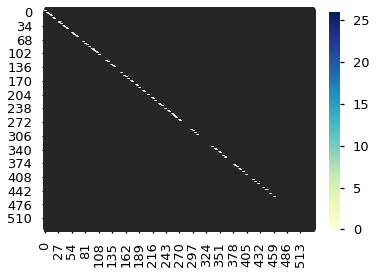

In [ ]:
sns.heatmap(cm,annot=True,cmap="YlGnBu")